In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Model
from Load_model import CNN_Net
import torchvision.datasets
from torchvision import datasets, transforms

2025-09-26 15:42:50.382276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.0.weight
model.0.bias
model.3.weight
model.3.bias
model.6.weight
model.6.bias
model.10.weight
model.10.bias
model.12.weight
model.12.bias
model.14.weight
model.14.bias
Model Load Sucessful


In [2]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_state_dict = torch.load('mnist_cnn_model.pth', map_location=device)

# Get all parameters
params = list(model_state_dict.items())
n_params = len(params)

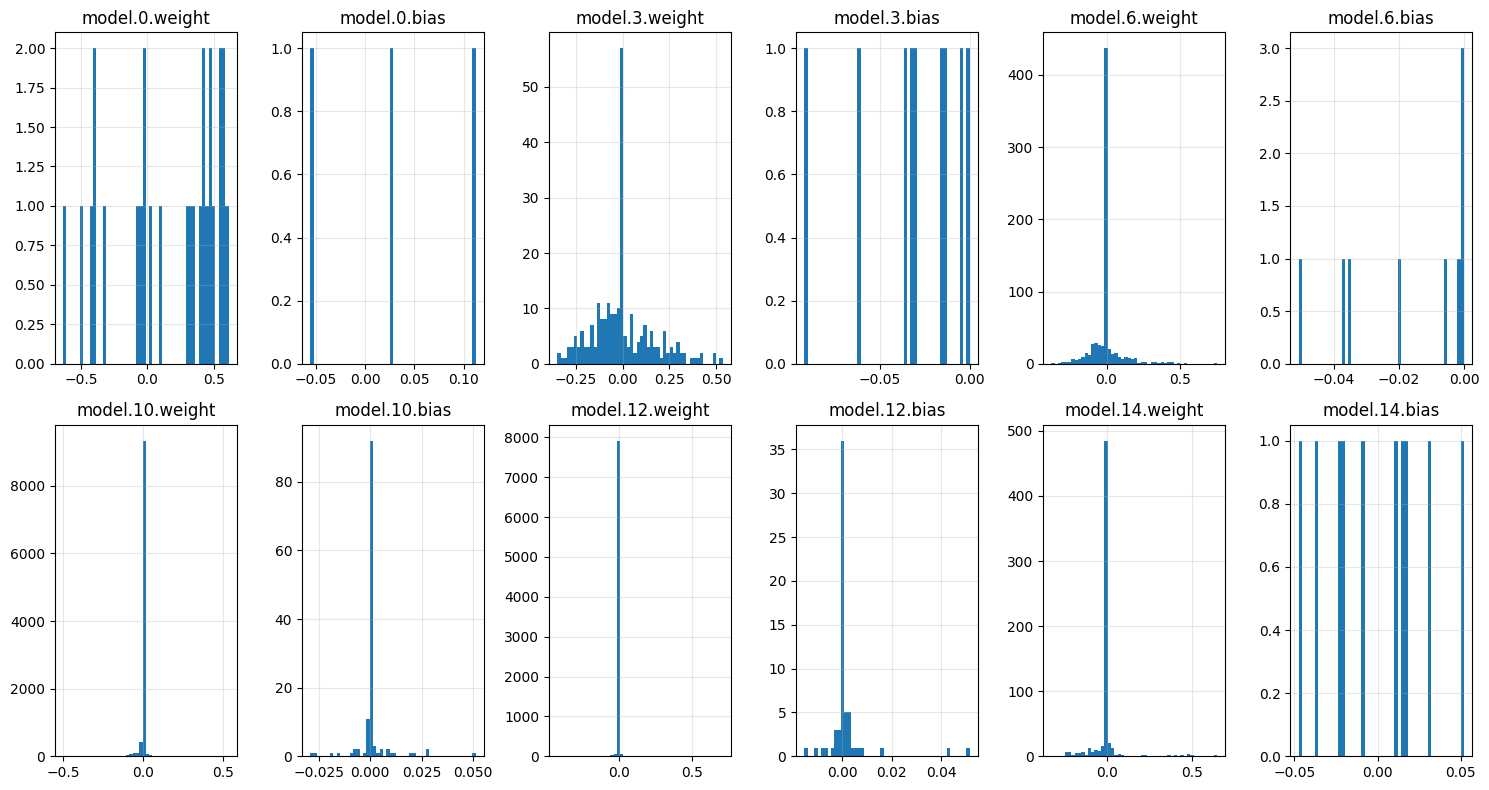

In [3]:
# Create subplots
fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 8))
axes = axes.flatten() if n_params > 1 else [axes]

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [4]:
from extractor import Extractor

# Load in model
model = CNN_Net()
model_state_dict = torch.load('mnist_cnn_model.pth', map_location='cpu')

extractor = Extractor(list(model.children()))
extractor.activate()

# Get model byte size
param_size = 0
buffer_size = 0

for param in model.parameters():
    param_size += param.nelement() * param.element_size()

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Size: {:.3f} MB'.format(size_all_mb))

Size: 0.078 MB


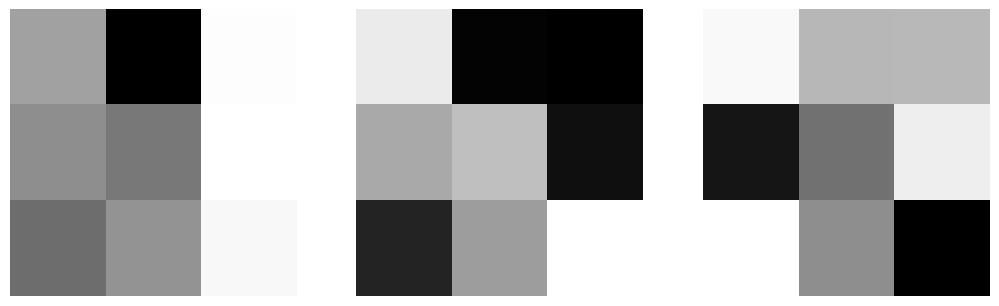

In [5]:
# Visualising the filters
plt.figure(figsize=(35, 35))
for index, filter in enumerate(extractor.CNN_weights[0]):
    plt.subplot(8, 8, index + 1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')

plt.show()

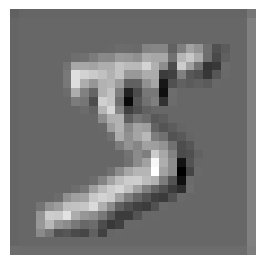

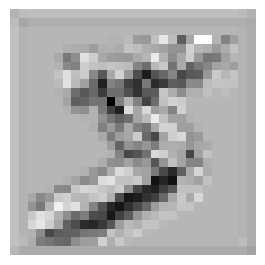

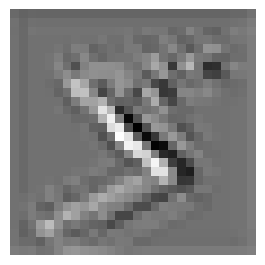

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
        root='./data',        
        train=True,           
        download=True,        
        transform=transform  
)

# one test image 
image, label = train_dataset[0]

featuremaps = [extractor.CNN_layers[0](image)]
for x in range(1, len(extractor.CNN_layers)):
    featuremaps.append(extractor.CNN_layers[x](featuremaps[-1]))

# Visualising the featuremaps
for x in range(len(featuremaps)):
    plt.figure(figsize=(30, 30))
    layers = featuremaps[x][0, :, :].detach()
    plt.subplot(8, 8, i + 1)
    plt.imshow(layers, cmap='gray')
    plt.axis('off')

plt.show()

In [7]:
# Post-training quantization with min-max quantization

# Clamping function
def clamp(params_q: np.array, lower_bound: int, upper_bound: int) -> np.array:
    """
    input: params_q = unquantizied parameter, lower_bound = -(2^(n-1) - 1), upper_bound = 2^(n-1)
    output: clamped parameter
    """
    params_q[params_q < lower_bound] = lower_bound
    params_q[params_q > upper_bound] = upper_bound
    return params_q

# symmetric int quantization
def symmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float]:
    """
    input: params = tensor, bits = bit size
    output: quantized = int8, scale = scaling factor for quantization
    """
    # Calculate the scale
    alpha = np.max(np.abs(params))
    scale = alpha / (2**(bits-1)-1)
    lower_bound = -2**(bits-1)
    upper_bound = 2**(bits-1)-1
    # Quantize the parameters
    quantized = clamp(np.round(params / scale), lower_bound, upper_bound).astype(np.int32)
    return quantized, scale

tensor model.0.weight scaling factor 0.004997492767870426: tensor([[[[ -79,  -99,  -85],
          [  -6,  -17,  -11],
          [ 113,   99,   80]]],


        [[[ -65,   22,   89],
          [  -4,   86,   94],
          [  94,  108,   63]]],


        [[[ 115,    5, -127],
          [ 109,   61,  -81],
          [  69,  122,   87]]]], dtype=torch.int32)
tensor model.0.bias scaling factor 0.0008834014879539609: tensor([-63, 127,  30], dtype=torch.int32)
tensor model.3.weight scaling factor 0.00421116454526782: tensor([[[[ 62,   1, -34],
          [ 72,  56,   7],
          [-22,  -5,  26]],

         [[-60, -81, -62],
          [ 21, -12, -63],
          [ 11,  12, -12]],

         [[-31, -61, -47],
          [ 48,  36,   9],
          [ -6,  42,  88]]],


        [[[-39, -18, -31],
          [-26, -51, -59],
          [-20, -53, -28]],

         [[-58,  23,  71],
          [-41,  43,  20],
          [-15,  34,  -7]],

         [[-52, -18,  -4],
          [-50,  -7,  60],
          [

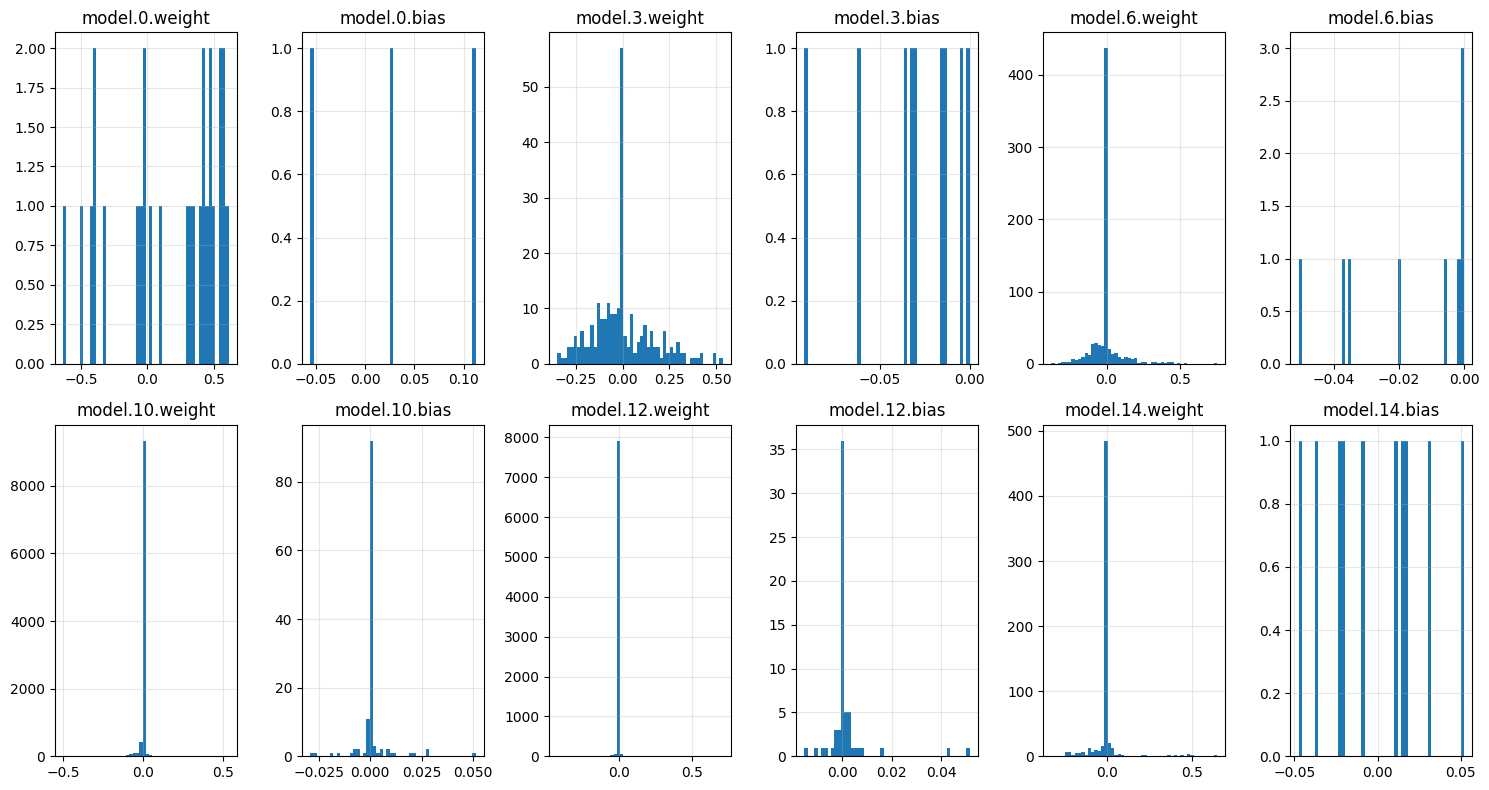

In [8]:
fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 8))
axes = axes.flatten() if n_params > 1 else [axes]
quant_tensors = {}
scaling_factors = []

# quantized tensors
for i, (name, tensor) in enumerate(params):
  original_shape = tensor.shape
  values = tensor.cpu().numpy().flatten()
  quantized_values = symmetric_quantization(values, 8)
  quantized_array = quantized_values[0]
  quantized_tensor = torch.from_numpy(quantized_array).reshape(original_shape)

  print(f"tensor {name} scaling factor {quantized_values[1]}: {quantized_tensor}")
  scaling_factors.append(quantized_values[1])
  quant_tensors[name] = quantized_tensor

  axes[i].hist(values, bins=50)
  axes[i].set_title(name)
  axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
  

In [9]:
# Upload quantized tensors to model through dequantization

def dequant(scale: float, quant_tensor, original_tensor):
  """
  input: scale = scaling facotr for quantization, quant_tensor = quantized array in int8, original_tensor = fp32 original tensor as array
  output: fp32_tensor = scaled up array from int 8 to fp32, max_error = quantization error
  """
  
  fp32_tensor = quant_tensor * scale
  quant_error = fp32_tensor - original_tensor
  max_error = np.max(np.abs(quant_error))

  return fp32_tensor, max_error

In [10]:
import importlib.util
import sys

# Load the module from the file path
spec = importlib.util.spec_from_file_location("model_testing", "/workspaces/MNIST_Digit_Recognition/lib/CNN_Model/model_testing.py")
model_testing = importlib.util.module_from_spec(spec)
sys.modules["model_testing"] = model_testing
spec.loader.exec_module(model_testing)

# Now you can access the class
TestModel = model_testing.test_model

def test_quantization_bitsizes(original_params, bit_sizes: np.array):
    """
    Test different bit sizes for quantization and return accuracy results
    
    Args:
        original_params: list of (name, tensor) tuples from original model
        bit_sizes: list of bit sizes to test
        test_loader: DataLoader for testing
        device: device to run on
    
    Returns:
        dict: {bit_size: accuracy} results
    """
    results = []
    
    for bits in bit_sizes:
        print(f"\nTesting {bits}-bit quantization...")
        
        # Quantize with current bit size
        quant_tensors = {}
        scaling_factors = []
        
        for name, tensor in original_params:
            params_np = tensor.cpu().numpy()
            quantized, scale = symmetric_quantization(params_np, bits)
            quant_tensors[name] = quantized
            scaling_factors.append(scale)

        # Dequantize
        dequantized_dict = {}
        for i, (name, tensor) in enumerate(original_params):
            original_shape = tensor.shape
            fp32_array, quant_error= dequant(scaling_factors[i], quant_tensors[name], tensor.cpu().numpy())
            fp32_tensor = torch.from_numpy(fp32_array).reshape(original_shape)
            dequantized_dict[name] = fp32_tensor

        print(f"Quantization Error: {quant_error:.5f} ...")
        model_tester = TestModel()

        # Test accuracy
        accuracy = model_tester.get_accuracy(dequantized_dict)
        results.append(accuracy)
        print(f"{bits}-bit accuracy: {accuracy:.2f}%")
    
    return results

In [11]:
int_values = [16, 12, 10, 8, 6, 4, 3, 2]
results = test_quantization_bitsizes(params, int_values)


Testing 16-bit quantization...
Quantization Error: 0.00000 ...
16-bit accuracy: 96.58%

Testing 12-bit quantization...
Quantization Error: 0.00001 ...
12-bit accuracy: 96.57%

Testing 10-bit quantization...
Quantization Error: 0.00005 ...
10-bit accuracy: 96.57%

Testing 8-bit quantization...
Quantization Error: 0.00020 ...
8-bit accuracy: 96.50%

Testing 6-bit quantization...
Quantization Error: 0.00080 ...
6-bit accuracy: 96.49%

Testing 4-bit quantization...
Quantization Error: 0.00332 ...
4-bit accuracy: 96.19%

Testing 3-bit quantization...
Quantization Error: 0.00814 ...
3-bit accuracy: 84.05%

Testing 2-bit quantization...
Quantization Error: 0.02270 ...
2-bit accuracy: 15.53%


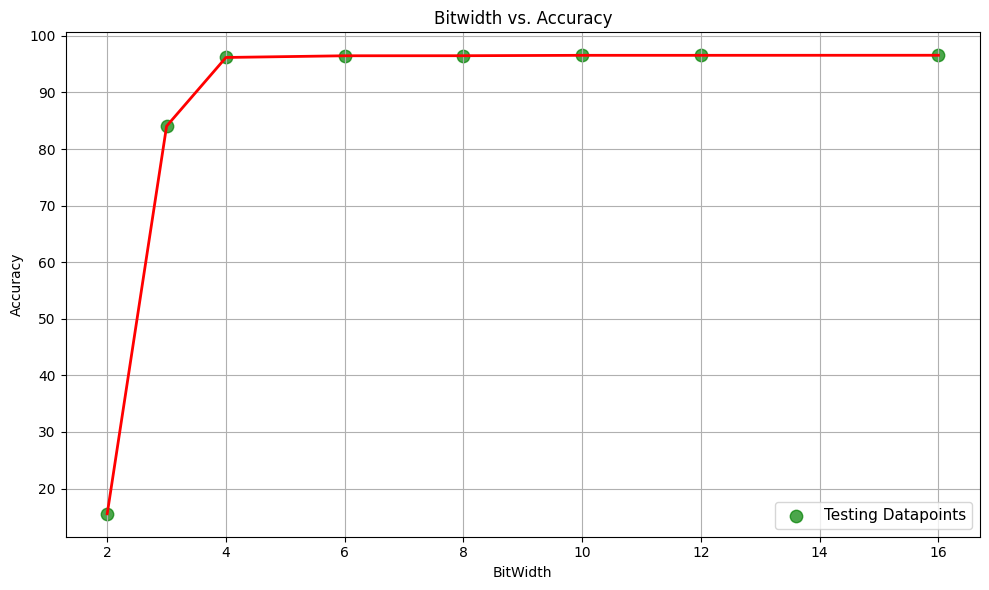

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(int_values, results, s=80, c='green', alpha=0.7, label='Testing Datapoints')
ax.plot(int_values, results, linewidth=2, c='r')
ax.set_title('Bitwidth vs. Accuracy')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()